# <center> Naive Bayes to Amazon Fine Food Reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Split data into train and test using time based slicing as 70%  train & 30% test.
3.	Perform featurization, BoW, tf-idf.
4.	Apply Naive Bayes on train data.
5.	Perform cross validation to find optimal alpha (Laplace Smoothing).
6.	Find important features for +ve and –ve class labels.
7.	To test the performance of the model, calculate accuracy,precision,recall,F1-score,confusion matrix(TPR,TNR,FPR,FNR)
8.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.


### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(BoW,TF-IDF) and calculate probabilistic class label values using naive bayes, which evaluates whether a review is positive or negative.<span>

---


In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning,module='gensim')
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import traceback
import sqlite3
import itertools
from nltk import FreqDist
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import make_scorer

### (1) Load dataset :

Dataset Shape : 
 (351237, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    297807
negative     53430
Name: Score, dtype: int64



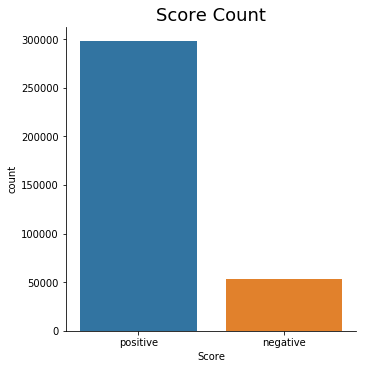

In [13]:
# Load 'finalDataSet.sqlite' in panda's daraframe.
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# Create connection object to load sqlite dataset
connection = sqlite3.connect('finalDataSet.sqlite')

# Load data into pandas dataframe.
reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

# Drop index column 
reviews_df = reviews_df.drop(columns=['index'])

# Convert timestamp to datetime.
reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

# Sort the data on the basis of time.
reviews_df = reviews_df.sort_values(by=['Time'])

print("Dataset Shape : \n",reviews_df.shape)
print("\nColumn Names: \n",reviews_df.columns)
print("\nTarget Class label : ")
print(reviews_df['Score'].value_counts())
print()

# Plot review counts
plot_count_values(reviews_df)

In [14]:
###--- All utility variables and functions ---###

# List of values for hyperparameter
range_parameter_values = [0.00001,0.0001,0.001,0.01,1,10,100]

# Training Error
train_error = []

# Test Error
test_error = []

# Test Error
list_alpha = []

# Target Classes
target_classes = ["negative", "positive"]

scoring_parameter = "Accuracy, Precision, Recall"

# http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter 
# for list allowed scoring values
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}

def get_most_common_words(classifier,vectorizer,top_n=None):
    ''' Get top n values in row and return them with their corresponding feature names.'''
    print()
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    top_negative = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:top_n]
    top_positive = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:top_n]
    
    complete_list = list()
    for index in range(0,top_n):
        holder = []
        n_value,n_word = top_negative[index]
        p_value,p_word = top_positive[index]
        holder.append(n_word)
        holder.append(n_value)
        holder.append(p_word)  
        holder.append(p_value)              
        complete_list.append(holder)       
    
    df = pd.DataFrame(complete_list,columns=['feature_negative', 'value_negative','feature_positive', 'value_positive'])  
    
    ptable = PrettyTable()
    ptable.title = "Feature Importance - {0} Most Common Features".format(top_n)
    ptable.field_names = ['Feature (-ve)', 'Empirical Log Probability (-ve)','Feature (+ve)', 'Empirical Log Probability (+ve)']
    
    for row in df.itertuples():
        ptable.add_row([row.feature_negative,row.value_negative,row.feature_positive,row.value_positive])
    
    print(ptable)
    print()
        

def apply_naive_bayes(optimal_alpha,training_features_matrix,training_target):
    '''
    This function performs naive bayes on the given data.
    '''   
    classifier = MultinomialNB(alpha=optimal_alpha)
    classifier.fit(training_features_matrix,training_target)  
    return classifier
    

def get_optimal_hyperparameter(x_train, y_train):
    '''
    This function, plots error and hyperparameter values and, then returns optimal hyperparameter value.    
    '''
    scores = dict()
    
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Hyperparamter versus Scoring Mean"
    ptable.field_names = ["Alpha Value", "Cross Validation Scoring Mean","Scoring Parameter Used"]
    
    # Perform 10-fold cross validation
    for a in range_parameter_values:
        classifier = MultinomialNB(alpha=a)        
        result = cross_val_score(classifier, x_train, y_train, cv=10, scoring= my_scorer)
        scores[a] = result.mean()
        ptable.add_row([a, scores[a], scoring_parameter])        
    
    # Print pretty table values  
    print(ptable)
    
    # Plot the value of alpha's(x-axis) and crosss validation scoring(accuracy,precision,recall)(y-axis)
    plt.plot(scores.keys(),scores.values())
    plt.xlabel("Value of alpha for Naive Bayes")
    plt.ylabel("Cross validated scoring - accuracy,precision,recall")
    plt.show()
    
    optimal_alpha = max(scores, key=scores.get)
    list_alpha.append(optimal_alpha)
    print("\nOptimal value of hyperparameter alpha is ",optimal_alpha)
        
    return optimal_alpha

def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (accuracy_score(y, yPred), 
            precision_score(y, yPred, pos_label=3, average='macro'), 
            recall_score(y, yPred, pos_label=3, average='macro'))

def my_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)    
    return a+p+r

def generate_report(optimal_alpha,testing_target,predicted_testing_target):
    '''
    This funtion generate reports like recall,precision,f1-score,confusion matrix.
    '''
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Classification Report with alpha = {0}".format(optimal_alpha)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(testing_target, predicted_testing_target,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,inner_dict['precision'],inner_dict['recall'],inner_dict['f1-score'],inner_dict['support']])
    
    # Print pretty table values
    print(ptable)
        
    print()
    print("\nAccuracy Score: ",accuracy_score(testing_target, predicted_testing_target))
    test_error.append(1-accuracy_score(testing_target, predicted_testing_target))
    print()
    cnf_mat = confusion_matrix(testing_target, predicted_testing_target)
    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=target_classes,title='Confusion Matrix')
    TN = cnf_mat[0,0]       
    FP = cnf_mat[0,1]  
    FN = cnf_mat[1,0]
    TP = cnf_mat[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))",TPR])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))",TNR])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))",FPR])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))",FNR])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))",ACC])
    
    # Print pretty table values
    print(ptable) 
    
    
       
def plot_count_values(reviews_df):   
    sn.catplot(x ="Score",kind='count',data=reviews_df,height=5)
    plt.title("Score Count", fontsize=18)
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def conclude():
ptable=PrettyTable()
ptable.title = "***Conclusion***"
ptable.field_names=["Dataset","Model","Hyperparameter","Train Error","Test Error"]
ptable.add_row(["Imbalanced","BoW --> Multinomial NB",list_alpha[0],str(round(train_error[0], 2)*100)+"%",str(round(test_error[0], 2)*100)+"%"])
ptable.add_row(["Balanced","BoW --> SMOTE --> Multinomial NB",list_alpha[1],str(round(train_error[1], 2)*100)+"%",str(round(test_error[1], 2)*100)+"%"])
ptable.add_row(["Imbalanced","TF-IDF --> Multinomial NB",list_alpha[2],str(round(train_error[2], 2)*100)+"%",str(round(test_error[2], 2)*100)+"%"])
ptable.add_row(["Balanced","TF-IDF --> SMOTE --> Multinomial NB",list_alpha[3],str(round(train_error[3], 2)*100)+"%",str(round(test_error[3], 2)*100)+"%"])
print(ptable)
    

def run_naive_bayes(features,target,testing_features,testing_target,vectorizer):    

    # Find optimal alpha
    optimal_alpha = get_optimal_hyperparameter(features,target)

    # Perform naive bayes
    classifier = apply_naive_bayes(optimal_alpha,features,target)
        
    # Make class predictions for testing_features
    # Also make class predictions for training_features(training error)
    predicted_testing_target = classifier.predict(testing_features)
    predicted_target = classifier.predict(features)
    train_error.append(1 - accuracy_score(target, predicted_target))       
        
    # Generate report
    generate_report(optimal_alpha,testing_target,predicted_testing_target)
    
    # Feature Importance    
    get_most_common_words(classifier,vectorizer,25) 


### (2) Convert review text to vector representation and perform Naive Bayes on the corresponding vector :
#### (2.1) Bag of Words (BoW) :

In [15]:
%%time

# Split data into 70% training and 30% testing.
training_features, testing_features, training_target, testing_target = train_test_split(reviews_df['CleanedText'].values, reviews_df['Score'].values, test_size=0.3,shuffle=False, random_state=0)

# Instantiate CountVectorizer (vectorizer)
bow_count_vectorizer = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
bow_count_vectorizer.fit(training_features)

# Examine the fitted vocabulary - 50 examples for demo.
print("\nFeatures : (sample of 50 features for demo purpose) \n")
print(bow_count_vectorizer.get_feature_names()[:50])

# Transform training and testing data(features) into a 'document-term matrix' or 'row-column matrix'
training_features_matrix_unbalanced = bow_count_vectorizer.transform(training_features)
testing_features_matrix = bow_count_vectorizer.transform(testing_features)

print("\nthe type of count vectorizer ",type(training_features_matrix_unbalanced))
print("the shape of BOW vectorizer ",training_features_matrix_unbalanced.get_shape())
print("the number of unique words ", training_features_matrix_unbalanced.get_shape()[1])



Features : (sample of 50 features for demo purpose) 

['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaagghh', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaahhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaahhhhten', 'aaaaaand', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaawsom', 'aaaah', 'aaaahhhhhh', 'aaaand', 'aaaarrrrghh', 'aaagh', 'aaah', 'aaahhh', 'aaahhhhhh', 'aabsolut', 'aachen', 'aacur', 'aad', 'aadp', 'aadult', 'aaf', 'aafco', 'aafter', 'aah', 'aahh', 'aalmost', 'aamazon', 'aamzon', 'aana', 'aand', 'aani', 'aap', 'aar', 'aardvark', 'aarp', 'aarrgghhhh', 'aarthur', 'aauc', 'ab', 'aback']

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (245865, 74398)
the number of unique words  74398
Wall time: 15.2 s



*********** Before SMOTE Alogorithm - Imbalanced Data ***********
Ratio of positive/negative points in original dataset is 5.573778775968557/1
Shape of train-feature data matrix is  (245865, 74398)
Shape of train-target nd-array is  (245865,)

+---------------------------------------------------------------------------+
|                     Hyperparamter versus Scoring Mean                     |
+-------------+-------------------------------+-----------------------------+
| Alpha Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+-------------+-------------------------------+-----------------------------+
|    1e-05    |       2.4683289089224933      | Accuracy, Precision, Recall |
|    0.0001   |       2.475044986201854       | Accuracy, Precision, Recall |
|    0.001    |       2.4846380466684237      | Accuracy, Precision, Recall |
|     0.01    |       2.4945730762929386      | Accuracy, Precision, Recall |
|      1      |       2.508399977890567       | Accur

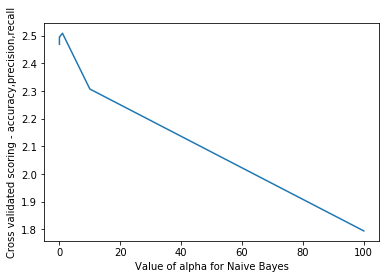


Optimal value of hyperparameter alpha is  1

+-----------------------------------------------------------------------------------------------+
|                              Classification Report with alpha = 1                             |
+----------------------+--------------------+--------------------+--------------------+---------+
| Class Lable/Averages |     Precision      |       Recall       |      F1-Score      | Support |
+----------------------+--------------------+--------------------+--------------------+---------+
|       negative       | 0.7213775416742993 | 0.6622939791456441 | 0.6905743095133713 |  17838  |
|       positive       | 0.9323108039777516 | 0.9478716841455891 | 0.9400268511122818 |  87534  |
|      micro avg       | 0.8995273886801047 | 0.8995273886801047 | 0.8995273886801047 |  105372 |
|      macro avg       | 0.8268441728260254 | 0.8050828316456167 | 0.8153005803128266 |  105372 |
|     weighted avg     | 0.8966027645273379 | 0.8995273886801047 | 0.897

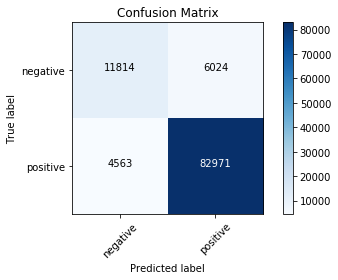


+---------------------------------------------------------------+
|                    Confusion Matrix Report                    |
+----------------------------------------+----------------------+
|                  Term                  |        Value         |
+----------------------------------------+----------------------+
|           TP (True Positive)           |        82971         |
|           TN (True Negative)           |        11814         |
|          FP (False Positive)           |         6024         |
|          FN (False Negative)           |         4563         |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9478716841455891  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.6622939791456441  |
| FPR (False Positive Rate)= FP/(FP+TN)) | 0.33770602085435586  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.052128315854410856 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.8995273886801047  |
+----------------------------------------+----------------------+

+-------

In [16]:
%%time

print("\n*********** Before SMOTE Alogorithm - Imbalanced Data ***********")
pos_neg = reviews_df['Score'].value_counts().tolist()
print("Ratio of positive/negative points in original dataset is {0}/1".format((pos_neg[0]/pos_neg[1])))
print("Shape of train-feature data matrix is ",training_features_matrix_unbalanced.get_shape())
print("Shape of train-target nd-array is ",training_target.shape)
print()

# Perform Naive Bayes on Imbalanced dataset.
try:
    run_naive_bayes(training_features_matrix_unbalanced
                   ,training_target
                   ,testing_features_matrix
                   ,testing_target
                   ,bow_count_vectorizer)
except Exception:
    traceback.print_exc()

<br/>
Data is higly imbalanced and biased towards positive review data points, so we need to balance the dataset with the help of BoW vectorizer and SMOTE algorithm.

<br/>



*********** After SMOTE Alogorithm - Balanced Data ***********
Shape of train-feature data matrix is  (420546, 74398)
Shape of train-target nd-array is  (420546,)

+---------------------------------------------------------------------------+
|                     Hyperparamter versus Scoring Mean                     |
+-------------+-------------------------------+-----------------------------+
| Alpha Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+-------------+-------------------------------+-----------------------------+
|    1e-05    |       2.6863312774628163      | Accuracy, Precision, Recall |
|    0.0001   |       2.6852212969331473      | Accuracy, Precision, Recall |
|    0.001    |       2.6833849722689016      | Accuracy, Precision, Recall |
|     0.01    |       2.6800878672726514      | Accuracy, Precision, Recall |
|      1      |        2.66120618816346       | Accuracy, Precision, Recall |
|      10     |       2.6349571933880602      | Accurac

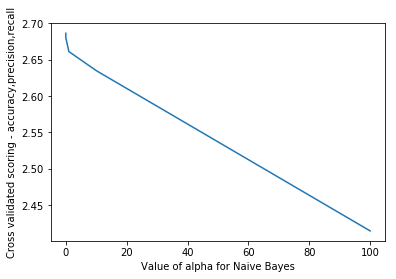


Optimal value of hyperparameter alpha is  1e-05

+-----------------------------------------------------------------------------------------------+
|                            Classification Report with alpha = 1e-05                           |
+----------------------+--------------------+--------------------+--------------------+---------+
| Class Lable/Averages |     Precision      |       Recall       |      F1-Score      | Support |
+----------------------+--------------------+--------------------+--------------------+---------+
|       negative       | 0.5528704612365064 | 0.7579885637403296 | 0.6393814725492979 |  17838  |
|       positive       | 0.9466483760937269 | 0.8750771128932757 | 0.9094568121104184 |  87534  |
|      micro avg       | 0.8552556656417265 | 0.8552556656417265 | 0.8552556656417265 |  105372 |
|      macro avg       | 0.7497594186651166 | 0.8165328383168027 | 0.7744191423298581 |  105372 |
|     weighted avg     | 0.8799873044122261 | 0.8552556656417265 | 0

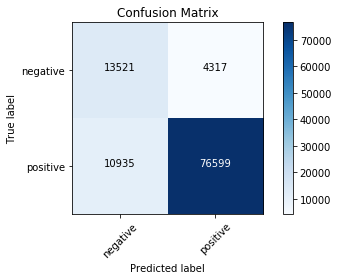


+--------------------------------------------------------------+
|                   Confusion Matrix Report                    |
+----------------------------------------+---------------------+
|                  Term                  |        Value        |
+----------------------------------------+---------------------+
|           TP (True Positive)           |        76599        |
|           TN (True Negative)           |        13521        |
|          FP (False Positive)           |         4317        |
|          FN (False Negative)           |        10935        |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.8750771128932757 |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.7579885637403296 |
| FPR (False Positive Rate)= FP/(FP+TN)) | 0.24201143625967036 |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.12492288710672425 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.8552556656417265 |
+----------------------------------------+---------------------+

+----------------------

In [17]:
# Apply SMOTE algorithm on training data points to balance the dataset.
training_features_matrix_balanced, training_target = SMOTE(ratio='minority').fit_sample(training_features_matrix_unbalanced, training_target)

print("\n*********** After SMOTE Alogorithm - Balanced Data ***********")
print("Shape of train-feature data matrix is ",training_features_matrix_balanced.get_shape())
print("Shape of train-target nd-array is ",training_target.shape)
print()

# Perform Naive Bayes on Balanced dataset.
try:
    run_naive_bayes(training_features_matrix_balanced
                   ,training_target
                   ,testing_features_matrix
                   ,testing_target
                   ,bow_count_vectorizer)
except Exception:
    traceback.print_exc()

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [18]:
%%time

# Split data into 70% training and 30% testing.
training_features, testing_features, training_target, testing_target = train_test_split(reviews_df['CleanedText'].values, reviews_df['Score'].values, test_size=0.3,shuffle=False, random_state=0)

# Instantiate CountVectorizer (vectorizer)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# learn the 'vocabulary' of the training data (occurs in-place)
tfidf_vectorizer.fit(training_features)

# Examine the fitted vocabulary - 50 examples for demo.
print("\nFeatures : (sample of 50 features for demo purpose) \n")
print(tfidf_vectorizer.get_feature_names()[:50])

# Transform training and testing data(features) into a 'document-term matrix' or 'row-column matrix'
training_features_matrix_unbalanced = tfidf_vectorizer.transform(training_features)
testing_features_matrix = tfidf_vectorizer.transform(testing_features)

print("\nthe type of count vectorizer ",type(training_features_matrix_unbalanced))
print("the shape of TF-IDF vectorizer ",training_features_matrix_unbalanced.get_shape())
print("the number of unique words ", training_features_matrix_unbalanced.get_shape()[1])



Features : (sample of 50 features for demo purpose) 

['aa', 'aa state', 'aaa', 'aaa aaa', 'aaa condit', 'aaa dont', 'aaa magazin', 'aaa perfect', 'aaa plus', 'aaa spelt', 'aaa tue', 'aaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa serious', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaargh wait', 'aaaaaaaaagghh', 'aaaaaaahhhhhh', 'aaaaaaahhhhhh raspberri', 'aaaaaaarrrrrggghhh', 'aaaaaaarrrrrggghhh back', 'aaaaaahhh', 'aaaaaahhh help', 'aaaaaahhhhhyaaaaaa', 'aaaaaahhhhhyaaaaaa fire', 'aaaaaahhhhten', 'aaaaaahhhhten fifteen', 'aaaaaand', 'aaaaaand kid', 'aaaaaawwwwwwwwww', 'aaaaaawwwwwwwwww depart', 'aaaaah', 'aaaaah awak', 'aaaaah satisfi', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaahhhhhhhhhhhhhhhh angel', 'aaaaawsom', 'aaaaawsom chump', 'aaaah', 'aaaah favorit', 'aaaah snob', 'aaaahhhhhh', 'aaaahhhhhh must', 'aaaand', 'aaaand theyr', 'aaaarrrrghh', 'aaaarrrrghh plus', 'aaagh', 'aaagh thrill', 'aaah']

the type of count vectorizer  <class 's

<br/>
Data is higly imbalanced and biased towards positive review data points, so we need to balance the dataset with the help of TF-IDF vectorizer and SMOTE algorithm.

<br/>



*********** Before SMOTE Alogorithm - Imbalanced Data ***********
Ratio of positive/negative points in original dataset is 5.573778775968557/1
Shape of train-feature data matrix is  (245865, 2218080)
Shape of train-target nd-array is  (245865,)

+---------------------------------------------------------------------------+
|                     Hyperparamter versus Scoring Mean                     |
+-------------+-------------------------------+-----------------------------+
| Alpha Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+-------------+-------------------------------+-----------------------------+
|    1e-05    |       2.359846584343212       | Accuracy, Precision, Recall |
|    0.0001   |        2.40487578983227       | Accuracy, Precision, Recall |
|    0.001    |       2.461430139104839       | Accuracy, Precision, Recall |
|     0.01    |       2.482152763143755       | Accuracy, Precision, Recall |
|      1      |       2.0856404133061277      | Acc

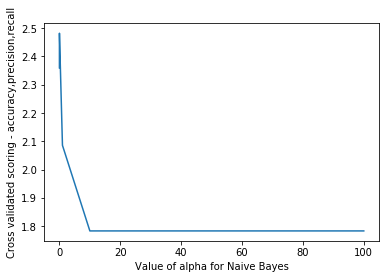


Optimal value of hyperparameter alpha is  0.01

+-----------------------------------------------------------------------------------------------+
|                            Classification Report with alpha = 0.01                            |
+----------------------+--------------------+--------------------+--------------------+---------+
| Class Lable/Averages |     Precision      |       Recall       |      F1-Score      | Support |
+----------------------+--------------------+--------------------+--------------------+---------+
|       negative       | 0.894528911768227  | 0.4188810404753896 | 0.5705776793555037 |  17838  |
|       positive       | 0.8931549490306022 | 0.9899353394109718 | 0.9390581567354637 |  87534  |
|      micro avg       | 0.893263865163421  | 0.893263865163421  | 0.893263865163421  |  105372 |
|      macro avg       | 0.8938419303994146 | 0.7044081899431807 | 0.7548179180454837 |  105372 |
|     weighted avg     | 0.8933875416293359 | 0.893263865163421  | 0.

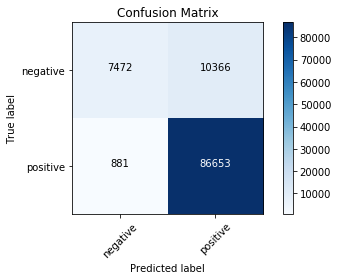


+---------------------------------------------------------------+
|                    Confusion Matrix Report                    |
+----------------------------------------+----------------------+
|                  Term                  |        Value         |
+----------------------------------------+----------------------+
|           TP (True Positive)           |        86653         |
|           TN (True Negative)           |         7472         |
|          FP (False Positive)           |        10366         |
|          FN (False Negative)           |         881          |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9899353394109718  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.4188810404753896  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.5811189595246103  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.010064660589028263 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.893263865163421   |
+----------------------------------------+----------------------+

+-------

In [19]:
%%time

print("\n*********** Before SMOTE Alogorithm - Imbalanced Data ***********")
pos_neg = reviews_df['Score'].value_counts().tolist()
print("Ratio of positive/negative points in original dataset is {0}/1".format((pos_neg[0]/pos_neg[1])))
print("Shape of train-feature data matrix is ",training_features_matrix_unbalanced.get_shape())
print("Shape of train-target nd-array is ",training_target.shape)
print()

# Perform Naive Bayes on Imbalanced dataset.
try:
    run_naive_bayes(training_features_matrix_unbalanced
                   ,training_target
                   ,testing_features_matrix
                   ,testing_target
                   ,tfidf_vectorizer)
except Exception:
    traceback.print_exc()


*********** After SMOTE Alogorithm - Balanced Data ***********
Shape of train-feature data matrix is  (420546, 2218080)
Shape of train-target nd-array is  (420546,)

+---------------------------------------------------------------------------+
|                     Hyperparamter versus Scoring Mean                     |
+-------------+-------------------------------+-----------------------------+
| Alpha Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+-------------+-------------------------------+-----------------------------+
|    1e-05    |       2.9699776751265654      | Accuracy, Precision, Recall |
|    0.0001   |       2.9686934501050466      | Accuracy, Precision, Recall |
|    0.001    |       2.9657387141458296      | Accuracy, Precision, Recall |
|     0.01    |       2.9565676261279075      | Accuracy, Precision, Recall |
|      1      |       2.8670695882875363      | Accuracy, Precision, Recall |
|      10     |       2.784113030515457       | Accur

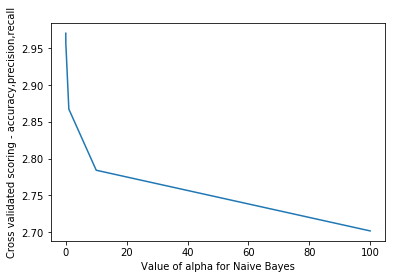


Optimal value of hyperparameter alpha is  1e-05

+-------------------------------------------------------------------------------------------------+
|                             Classification Report with alpha = 1e-05                            |
+----------------------+--------------------+---------------------+---------------------+---------+
| Class Lable/Averages |     Precision      |        Recall       |       F1-Score      | Support |
+----------------------+--------------------+---------------------+---------------------+---------+
|       negative       | 0.7758705247670427 | 0.26606121762529433 | 0.39624295554164063 |  17838  |
|       positive       | 0.8680973250717848 |  0.9843375145657687 |  0.922570386907152  |  87534  |
|      micro avg       | 0.8627434233003075 |  0.8627434233003075 |  0.8627434233003075 |  105372 |
|      macro avg       | 0.8219839249194137 |  0.6251993660955315 |  0.6594066712243963 |  105372 |
|     weighted avg     | 0.8524846227994924 |  0.8

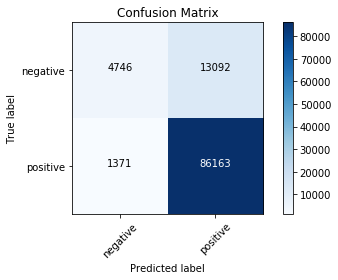


+--------------------------------------------------------------+
|                   Confusion Matrix Report                    |
+----------------------------------------+---------------------+
|                  Term                  |        Value        |
+----------------------------------------+---------------------+
|           TP (True Positive)           |        86163        |
|           TN (True Negative)           |         4746        |
|          FP (False Positive)           |        13092        |
|          FN (False Negative)           |         1371        |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9843375145657687 |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.26606121762529433 |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.7339387823747057 |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.01566248543423127 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.8627434233003075 |
+----------------------------------------+---------------------+

+----------------------

In [20]:
# Apply SMOTE algorithm on training data points to balance the dataset.
training_features_matrix_balanced, training_target = SMOTE(ratio='minority').fit_sample(training_features_matrix_unbalanced, training_target)

print("\n*********** After SMOTE Alogorithm - Balanced Data ***********")
print("Shape of train-feature data matrix is ",training_features_matrix_balanced.get_shape())
print("Shape of train-target nd-array is ",training_target.shape)
print()

# Perform Naive Bayes on Balanced dataset.
try:
    run_naive_bayes(training_features_matrix_balanced
                   ,training_target
                   ,testing_features_matrix
                   ,testing_target
                   ,tfidf_vectorizer)
except Exception:
    traceback.print_exc()

---
### Conclusion :
---

In [21]:
conclude()

+-------------------------------------------------------------------------------------------------------+
|                                            ***Conclusion***                                           |
+------------+-------------------------------------+----------------+-------------+---------------------+
|  Dataset   |                Model                | Hyperparameter | Train Error |      Test Error     |
+------------+-------------------------------------+----------------+-------------+---------------------+
| Imbalanced |        BoW --> Multinomial NB       |       1        |     8.0%    |        10.0%        |
|  Balanced  |   BoW --> SMOTE --> Multinomial NB  |     1e-05      |     9.0%    | 14.000000000000002% |
| Imbalanced |      TF-IDF --> Multinomial NB      |      0.01      |     0.0%    |        11.0%        |
|  Balanced  | TF-IDF --> SMOTE --> Multinomial NB |     1e-05      |     0.0%    | 14.000000000000002% |
+------------+--------------------------------

---
### Observations :
---

> 1. Here, Naive Bayes classifier is applied on complete dataset(~364K).
> 2. Given dataset is imbalanced in nature (postive reviews:negative reviews = 5.57/1).
> 3. 10-fold cross validation technique is applied to calculate optimal hyperparameter.
> 4. Initially we performed naive bayes classifier on imbalanced dataset with hyperparameter value of alpha is 1.
> 5. SMOTE algorithm is used to balance out the positive and negative reviews.
> 6. Balanced dataset's confusion matrix produces better result than Imbalanced dataset.
> 7. Techniques like Random Under/Over-Sampling, Variation of SMOTE algorithms can be used to balance out the dataset, which may result in better accuracy and confusion matrix values.


